# p-p chain vs. CNO

We will explore the p-p chain and the CNO cycle to learn which rates are the slowest in each and when each dominates inside of stars.

In [1]:
import pynucastro as pyna

We start by getting the rates from the [JINA ReacLib database](https://reaclib.jinaweb.org/index.php).  This has 80,000+ reaction rates in a standardized format.

In [2]:
rl = pyna.ReacLibLibrary()

## Simple p-p chain

We'll focus on the main [p-p chain](https://en.wikipedia.org/wiki/Proton%E2%80%93proton_chain)  and get the 3 rates involved in that.

In [3]:
pp_rates = ["p(p,)d",
            "d(p,g)he3",
            "he3(he3,pp)he4"]
rates = rl.get_rate_by_name(pp_rates)

We can look at which rates it pulled in:

In [4]:
for r in rates:
    print(r)

p + p ⟶ H2 + e⁺ + 𝜈
p + p + e⁻ ⟶ H2 + 𝜈
H2 + p ⟶ He3 + 𝛾
He3 + He3 ⟶ p + p + He4


Note that ReacLib actually splits the p+p rate into two.  We will add them together.

We can look at the temperature dependence of one of these rates

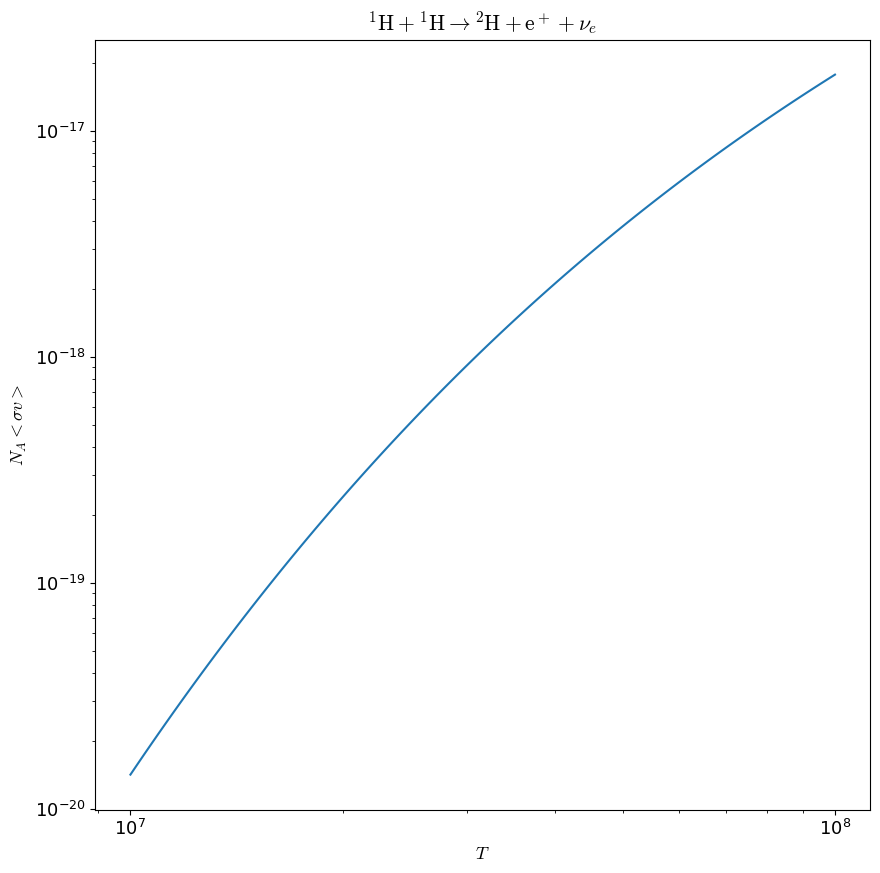

In [5]:
r = rates[0]
fig = r.plot(Tmin=1.e7, Tmax=1.e8)

We see that it is very temperature dependent

Next we build our network (we'll use a `RateCollection`) with these rates

In [6]:
net_pp = pyna.RateCollection(rates=rates)

We can create a thermodynamic state approximating the center of the Sun and evaluate the rates

In [7]:
T = 1.5e7
rho = 150
comp = pyna.Composition(net_pp.unique_nuclei)
comp.set_solar_like()

In [8]:
net_pp.evaluate_rates(rho, T, comp)

{p + p ⟶ H2 + e⁺ + 𝜈: 2.978374743269655e-18,
 p + p + e⁻ ⟶ H2 + 𝜈: 1.357778476769111e-20,
 H2 + p ⟶ He3 + 𝛾: 0.005874533290651895,
 He3 + He3 ⟶ p + p + He4: 1.849294558580789e-13}

We see from this that the first reaction, p + p, is by far the slowest.

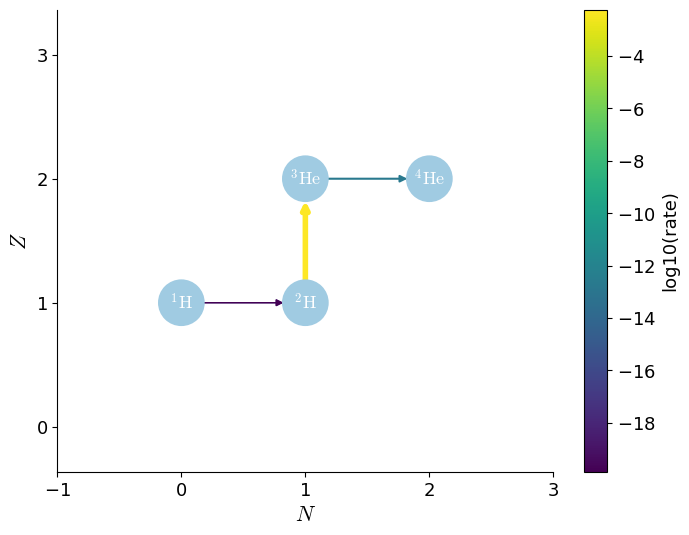

In [9]:
fig = net_pp.plot(rho=rho, T=T, comp=comp, hide_xp=True, always_show_alpha=True)

We can therefore approximate the p-p chain based on the slowest rate.  If we express the rate as:

$$r = r_0 \left (\frac{T}{T_0}\right )^\nu$$

then we can find the exponent $\nu$ about some temperature $T_0$

In [10]:
r_pp = net_pp.get_rate_by_name("p(p,)d")[0]
T0 = 1.5e7
r_pp.get_rate_exponent(T0)

3.9735120801889896

Around the conditions in the Sun, the p-p chain has a temperature dependence of $\sim T^4$

## CNO

Now we consider the main CNO cycle.  This involves 6 rates

In [11]:
cno_rates = ["c12(p,g)n13",
             "c13(p,g)n14",
             "n13(,)c13",
             "n14(p,g)o15",
             "n15(p,a)c12",
             "o15(,)n15"]
rates = rl.get_rate_by_name(cno_rates)

In [12]:
for r in rates:
    print(r)

C12 + p ⟶ N13 + 𝛾
C13 + p ⟶ N14 + 𝛾
N13 ⟶ C13 + e⁺ + 𝜈
N14 + p ⟶ O15 + 𝛾
N15 + p ⟶ He4 + C12
O15 ⟶ N15 + e⁺ + 𝜈


In [13]:
net_cno = pyna.RateCollection(rates=rates)

In [14]:
comp = pyna.Composition(net_cno.unique_nuclei)
comp.set_solar_like()

Again we can look evaluate each of the rates:

In [15]:
net_cno.evaluate_rates(rho, T, comp)

{C12 + p ⟶ N13 + 𝛾: 1.0467759242295144e-17,
 C13 + p ⟶ N14 + 𝛾: 3.176211597339995e-17,
 N13 ⟶ C13 + e⁺ + 𝜈: 2.9720852738029567e-07,
 N14 + p ⟶ O15 + 𝛾: 1.7295781984662848e-20,
 N15 + p ⟶ He4 + C12: 6.954822248932605e-16,
 O15 ⟶ N15 + e⁺ + 𝜈: 1.2625681768893481e-06}

Now we see that the ${}^{14}\mathrm{N}(p,\gamma){}^{15}\mathrm{O}$ rate is the slowest.

In [16]:
r_cno = net_cno.get_rate_by_name("n14(p,g)o15")

This is a much steeper function of temperature.  Let's explore the temperature dependence around a few points

In [17]:
for T in [1.e7, 2.e7, 3.e7, 4.e7]:
    print(f"T = {T}, nu = {r_cno.get_rate_exponent(T):8.5f}")

T = 10000000.0, nu = 22.82962
T = 20000000.0, nu = 17.96637
T = 30000000.0, nu = 15.60186
T = 40000000.0, nu = 14.11535


So it varies from $T^{23}$ to $T^{14}$ in a temperature range that includes the Sun's core.

Here's what the CNO cycle looks like

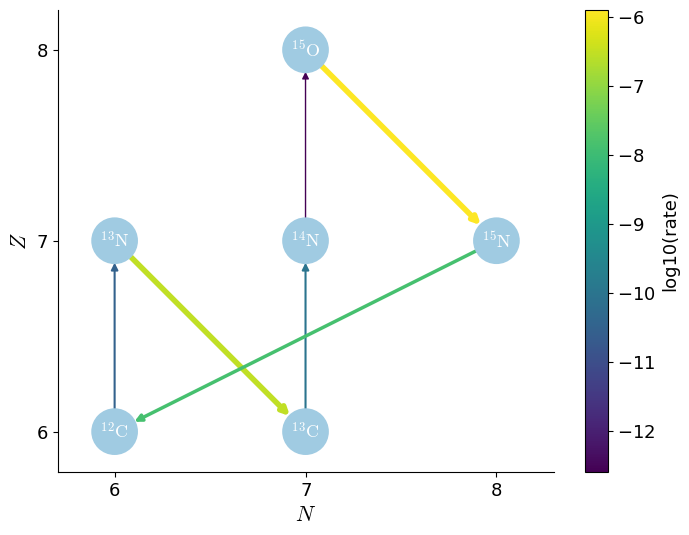

In [18]:
fig = net_cno.plot(rho=rho, T=T, comp=comp, hide_xp=True)

## Comparing p-p vs. CNO

The temperature dependence suggests that if the temperature were a little higher, then CNO would go faster then p-p.  We can plot the two rate-limiting rates on the same axes

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
Ts = np.logspace(6.8, 8, 50)

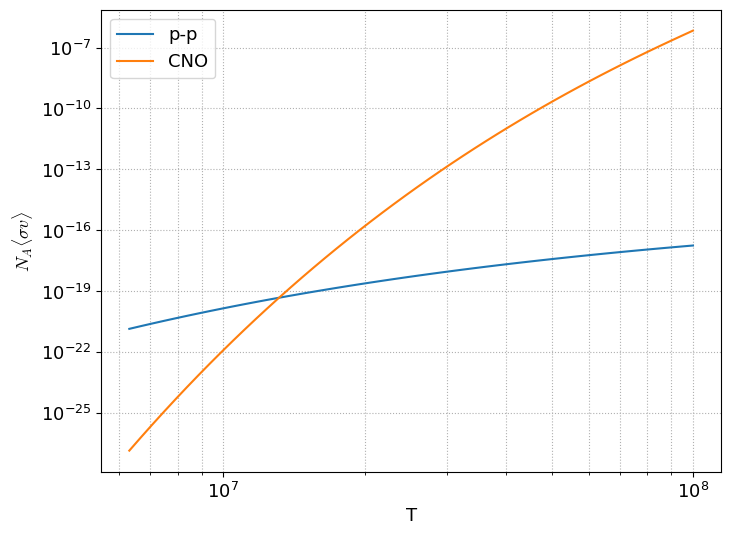

In [21]:
fig, ax = plt.subplots()

ax.loglog(Ts, [r_pp.eval(q) for q in Ts], label="p-p")
ax.loglog(Ts, [r_cno.eval(q) for q in Ts], label="CNO")
ax.set_xlabel("T")
ax.set_ylabel(r"$N_A\langle \sigma v \rangle$")
ax.grid(linestyle=":", which="both")
leg = ax.legend()

Notice that they cross over at a temperature just hotter than the Sun's core.  This means that stars more massive than the Sun (actually, about $1.5~M_\odot$) are powered by CNO and less massive stars are powered by p-p.  The strong $T$ dependence of CNO will play a role in determining the structure of those more massive stars.